# Анализ данных с временой структурой
# Проект 2

#### Участники:<br>
**Ванифатов Кирилл**<br>
**Молоков Андрей**

Задача:
Построить автоматизированный пайплайн для прогнозирования значений временного ряда

Требования:
- Выбор оптимизируемой метрики должен быть основан на потребностях бизнеса
- Модель может использовать внешние факторы (см подсказки)
- Модель должна иметь модуль отбора признаков
- Метод отбора должен быть болеее стабильным относительно альтернатив
- Сравнение должно быть проведено минимум с одним методом из каждой категории: встроенные, оберточные и фильтрационные
- При этом как минимум одна из альтернатив должа исследовать нелинейную зависимость
- Модель должна автоматически подбирать гиперпараметры, оптимизируя целевую метрику
- Для модели должна быть подобрана частота калибровки, если модель калибруется долго, и проверена ее достаточность
- Блоки должны быть подписаны и кратко описаны (чем руководствовались при реализации, как работает)
- Модель должна автоматически дообучаться
- Все модули должны работать без ручных корректировок
- Выбор периода для дообучения должен быть обоснован
- В модели должен быть модуль выявления разладки для подачи сигнала о возможной необходимости переключения на ручное управление процессом/внеплановое дообучение

Подсказки:
- Можно использовать факторы, сконструированные из таргета (лаги, средние и т.п.)
- Могут помочь макроэкономические факторы
- Могут помочь даты налоговых дней

Описание бизнес-процесса:
- Прогнозная величина позволяет установить сальдо поступлений и списаний за день
- На основании прогноза позиционер (управляет ликвидностью) принимает решение о выделении средств на размещение на рынке деривативов для получения дополнительной маржи (доходность считать примерно ключ+0.5%)
- В случае, если на конец дня образуется профицит ликвидности, его можно разместить в ЦБ по overnight ставке, равной ключу-0.9%
- В случае, если на конец дня образуется дефицит ликвидности, его можно покрыть за счет займа по overnight ставке, равной ключ+1%

1. выбор метрики
2. сравнение разных методов отбора признаков
3. пайплайн обучения
4. подбор гиперпараметров
5. дообучение, обработка данных

In [17]:
!pip3 install matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 708.1 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 4.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 1.2 MB/s eta 0:00:00a 0:00:01


In [65]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

import warnings 
warnings.filterwarnings('ignore')

In [66]:
data = pd.read_excel('Project_Data.xlsx')
data.shape

(1543, 4)

In [67]:
data

,Date,Income,Outcome,Balance
0,2017-01-09 00:00:00.000,1.343028,1.487865,-0.155904
1,2017-01-10 00:00:00.000,1.068610,1.194182,-0.125572
2,2017-01-11 00:00:00.000,0.944429,0.936663,0.007767
3,2017-01-12 00:00:00.000,1.672202,0.875379,0.800391
4,2017-01-13 00:00:00.000,0.955924,0.975645,-0.019721
...,...,...,...,...
1538,2021-03-27 00:00:00.000,0.000000,0.000000,0.000000
1539,2021-03-28 00:00:00.000,0.000000,0.000000,0.000000
1540,2021-03-29 00:00:00.000,2.356883,3.370738,-1.017679
1541,2021-03-30 00:00:00.000,2.317382,2.567554,-0.259687


# Обоснование выбора метрики для оптимизации

Для выбора метрики важно понимать последствия ошибок. 
- Недооценка сальдо (прогноз ниже фактического). Отсутсвие возможности разместить больше средств на рынке деривативов. То есть потери прибыли в размере = value * (credit_rate + 0.5)/365.
- Переоценка сальдо (прогноз выше фактического). Допуск дефицит, что приведет к необходимости заимствования по высокой ставке (ключ + 1%), увеличивая затраты. То есть потери прибыли в размере = value * (credit_rate + 1)/365.

Ошибка по переоценке сальдо имеет большие потери, но оба варианта сильно зависят от разницы между прогнозом и фактическим значением

Рассмотрим несколько метрик и их применимость:

MAE (Mean Absolute Error):
- Непосредственно измеряет среднюю абсолютную ошибку, что соответствует требованию заказчика (ошибка ≤ 0.42).
- Показывает среднее отклонение прогноза от фактического сальдо.
- Устойчива к знаку ошибки, что важно для сальдо, которое может быть положительным или отрицательным.
- Линейно штрафует ошибки, что отражает финансовые последствия, так как затраты/упущенная выгода пропорциональны величине ошибки.
- Не учитывает квадратичные эффекты, если крупные ошибки имеют непропорционально большие последствия.


MSE (Mean Squared Error):
- Сильнее штрафует большие ошибки из-за квадратичной зависимости, что может быть полезно, если крупные отклонения критичны.
- Менее интерпретируема в контексте требования заказчика (0.42 в абсолютном значении).
- Чувствительна к выбросам, что может исказить оптимизацию, если в данных есть аномалии (например, в налоговые дни).

RMSE (Root Mean Squared Error):
- Сохраняет интерпретируемость в единицах исходной переменной (как MAE).
- Учитывает большие ошибки сильнее, чем MAE.

Custom Loss (например, асимметричная потеря):<br>
Можно разработать метрику, которая по-разному штрафует переоценку и недооценку сальдо, учитывая разницу в доходности/затратах (например, +0.5% для деривативов vs. +1% для заимствований).
- Точно отражает финансовые последствия.
- Сложнее реализовать и оптимизировать.

В датасете есть дни с нулевым сальдо (например, выходные), а также потенциальные аномалии (например, налоговые дни). MAE менее чувствительна к выбросам, чем MSE или RMSE, что делает ее более стабильной для оптимизации. MAE легко объяснить бизнесу (средняя ошибка в единицах сальдо) и использовать для мониторинга качества модели. Баланс ошибок: MAE одинаково штрафует переоценку и недооценку, что подходит, так как оба типа ошибок имеют схожие финансовые последствия (хотя с разной величиной). Если потребуется учесть асимметрию, можно позже доработать модель с кастомной метрикой.

# Feature Engineering

In [68]:
data['Date'] = pd.to_datetime(data['Date']).dt.date
data = data.set_index('Date')
data

,Income,Outcome,Balance
Date,,,
2017-01-09,1.343028,1.487865,-0.155904
2017-01-10,1.068610,1.194182,-0.125572
2017-01-11,0.944429,0.936663,0.007767
2017-01-12,1.672202,0.875379,0.800391
2017-01-13,0.955924,0.975645,-0.019721
...,...,...,...
2021-03-27,0.000000,0.000000,0.000000
2021-03-28,0.000000,0.000000,0.000000
2021-03-29,2.356883,3.370738,-1.017679


In [ ]:
def create_balance_features(df, target_col='Balance'):
    """
    Создает фичи из таргета Balance: лаги, скользящие средние, разности и др.
    
    Parameters:
    df (pd.DataFrame): DataFrame с данными, содержащий столбец Balance
    target_col (str): Название столбца таргета (по умолчанию 'Balance')
    
    Returns:
    pd.DataFrame: DataFrame с новыми фичами
    """
    df = df.copy()
    
    # Лаги (1, 2, 3, 7 дней назад)
    for lag in [1, 2, 3, 7]:
        df[f'lag_{lag}'] = df[target_col].shift(lag)
        
    # Rolling Statistics
   
    windows = [3, 7, 14]

    for window in windows:
        # Скользящие средние
        df[f'roll_mean_{window}'] = df[target_col].rolling(window=window, min_periods=1).mean()
        # Скользящее стандартное отклонение
        df[f'roll_std_{window}'] = df[target_col].rolling(window=window, min_periods=1).std()
        # Скользящий минимум
        df[f'roll_min_{window}'] = df[target_col].rolling(window=window, min_periods=1).min()
        # Скользящий максимум
        df[f'roll_max_{window}'] = df[target_col].rolling(window=window, min_periods=1).max()
        # Скользящая сумма
        df[f'roll_sum_{window}'] = df[target_col].rolling(window=window, min_periods=1).sum()
    
    # Разности (первого порядка)
    df['diff_1'] = df[target_col].diff(1)
    df['diff_2'] = df[target_col].diff(2)
    
    # Кумулятивная сумма и среднее
    df['cumsum'] = df[target_col].cumsum()
    df['cummean'] = df[target_col].expanding().mean()
    
    # Отношение текущего значения к скользящему среднему
    for window in [3, 7]:
        df[f'ratio_ma_{window}'] = df[target_col] / df[f'roll_mean_{window}']
    
    # Отношение к предыдущему значению
    df['ratio_lag_1'] = df[target_col] / df[f'lag_1']
    
    data[data == np.inf] = 1e10
    data[data == -np.inf] = -1e10
    df = df.dropna()
    
    return df

data = create_balance_features(data)
data.head()

,Income,Outcome,Balance,lag_1,lag_2,lag_3,lag_7,roll_mean_3,roll_std_3,roll_min_3,...,roll_min_14,roll_max_14,roll_sum_14,diff_1,diff_2,cumsum,cummean,ratio_ma_3,ratio_ma_7,ratio_lag_1
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-16,1.082341,1.024345,0.057996,0.000000,0.000000,-0.019721,-0.155904,0.019332,0.033484,0.000000,...,-0.155904,0.800391,0.564957,0.057996,0.057996,0.564957,0.070620,3.000000,0.563181,inf
2017-01-17,0.896334,1.448364,-0.548519,0.057996,0.000000,0.000000,-0.125572,-0.163507,0.334688,-0.548519,...,-0.548519,0.800391,0.016438,-0.606515,-0.548519,0.016438,0.001826,3.354702,-12.888378,-9.457799
2017-01-18,0.754759,0.879560,-0.124801,-0.548519,0.057996,0.000000,0.007767,-0.205108,0.311130,-0.548519,...,-0.548519,0.800391,-0.108363,0.423717,-0.182798,-0.108363,-0.010836,0.608467,-5.283515,0.227524
2017-01-19,0.949877,0.955268,-0.005391,-0.124801,-0.548519,0.057996,0.800391,-0.226237,0.285419,-0.548519,...,-0.548519,0.800391,-0.113754,0.119411,0.543128,-0.113754,-0.010341,0.023828,0.058921,0.043194
2017-01-20,1.024187,1.138087,-0.113900,-0.005391,-0.124801,-0.548519,-0.019721,-0.081364,0.066020,-0.124801,...,-0.548519,0.800391,-0.227654,-0.108510,0.010901,-0.227654,-0.018971,1.399883,1.085334,21.129018


In [82]:
data.columns

Index(['Income', 'Outcome', 'Balance', 'lag_1', 'lag_2', 'lag_3', 'lag_7',
       'roll_mean_3', 'roll_std_3', 'roll_min_3', 'roll_max_3', 'roll_sum_3',
       'roll_mean_7', 'roll_std_7', 'roll_min_7', 'roll_max_7', 'roll_sum_7',
       'roll_mean_14', 'roll_std_14', 'roll_min_14', 'roll_max_14',
       'roll_sum_14', 'diff_1', 'diff_2', 'cumsum', 'cummean', 'ratio_ma_3',
       'ratio_ma_7', 'ratio_lag_1'],
      dtype='object')

# добавление макроэкономических факторов

- ключевая ставка
- инфляция
- ВВП
- MosPrime
- уровень безработицы
- государственный дефицит/профицит бюджета
- индекс moex
- даты налоговых дней

In [70]:
credit_rate_inflation = pd.read_excel('Инфляция и ключевая ставка Банка России_F01_01_2017_T25_04_2025.xlsx')
credit_rate_inflation.shape

(99, 4)

In [71]:
credit_rate_inflation

,Дата,"Ключевая ставка, % годовых","Инфляция, % г/г",Цель по инфляции
0,3.2025,21.00,10.34,4
1,2.2025,21.00,10.06,4
2,1.2025,21.00,9.92,4
3,12.2024,21.00,9.52,4
4,11.2024,21.00,8.88,4
...,...,...,...,...
94,5.2017,9.25,4.10,4
95,4.2017,9.75,4.10,4
96,3.2017,9.75,4.30,4
97,2.2017,10.00,4.60,4


In [72]:
credit_rate = pd.read_excel('Инфляция и ключевая ставка Банка России_F01_01_2017_T25_04_2025.xlsx')
credit_rate

,Дата,"Ключевая ставка, % годовых","Инфляция, % г/г",Цель по инфляции
0,3.2025,21.00,10.34,4
1,2.2025,21.00,10.06,4
2,1.2025,21.00,9.92,4
3,12.2024,21.00,9.52,4
4,11.2024,21.00,8.88,4
...,...,...,...,...
94,5.2017,9.25,4.10,4
95,4.2017,9.75,4.10,4
96,3.2017,9.75,4.30,4
97,2.2017,10.00,4.60,4


Добавить дф про ключевую ставку. размещение и займ

на нее мы домножаем баланс на следующий день

# Модуль детекции аномалий

Обнаружено аномалий: 45 из 45 добавленных аномалий


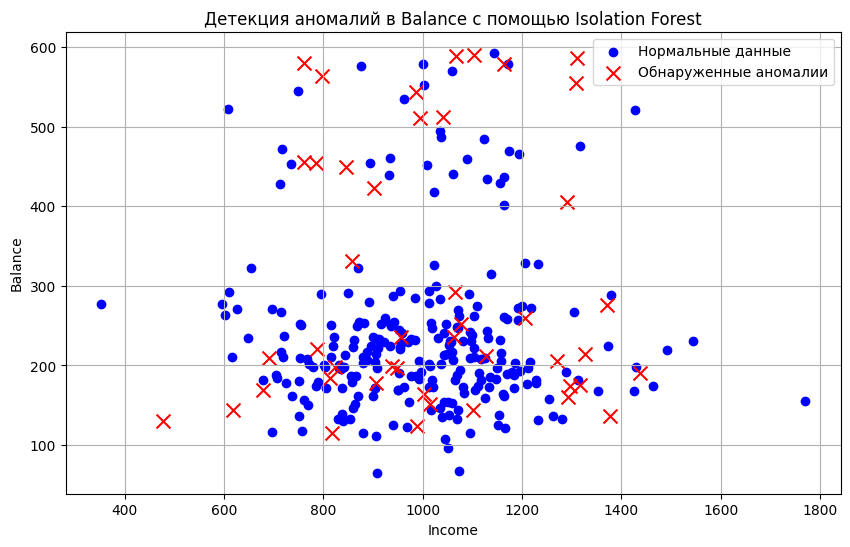

In [ ]:
from sklearn.ensemble import IsolationForest

# Предполагается, что данные уже загружены в DataFrame
# Если данных нет, замените на реальный путь к файлу или DataFrame
# Пример: df = pd.read_csv('your_data.csv')
# Для демонстрации создадим синтетический DataFrame
np.random.seed(42)
n_samples = 300
df = pd.DataFrame({
    'Income': np.random.normal(1000, 200, n_samples),
    'Outcome': np.random.normal(800, 150, n_samples),
    'Balance': np.random.normal(200, 50, n_samples),
    'lag_1': np.random.normal(200, 50, n_samples),
    'lag_2': np.random.normal(200, 50, n_samples),
    'lag_3': np.random.normal(200, 50, n_samples),
    'lag_7': np.random.normal(200, 50, n_samples),
    'roll_mean_3': np.random.normal(200, 50, n_samples),
    'roll_std_3': np.random.normal(20, 5, n_samples),
    'roll_min_3': np.random.normal(150, 30, n_samples),
    'roll_max_3': np.random.normal(250, 30, n_samples),
    'roll_sum_3': np.random.normal(600, 100, n_samples),
    'roll_mean_7': np.random.normal(200, 50, n_samples),
    'roll_std_7': np.random.normal(20, 5, n_samples),
    'roll_min_7': np.random.normal(150, 30, n_samples),
    'roll_max_7': np.random.normal(250, 30, n_samples),
    'roll_sum_7': np.random.normal(1400, 200, n_samples),
    'roll_mean_14': np.random.normal(200, 50, n_samples),
    'roll_std_14': np.random.normal(20, 5, n_samples),
    'roll_min_14': np.random.normal(150, 30, n_samples),
    'roll_max_14': np.random.normal(250, 30, n_samples),
    'roll_sum_14': np.random.normal(2800, 400, n_samples),
    'diff_1': np.random.normal(0, 10, n_samples),
    'diff_2': np.random.normal(0, 10, n_samples),
    'cumsum': np.random.normal(1000, 300, n_samples),
    'cummean': np.random.normal(200, 50, n_samples),
    'ratio_ma_3': np.random.normal(1, 0.1, n_samples),
    'ratio_ma_7': np.random.normal(1, 0.1, n_samples),
    'ratio_lag_1': np.random.normal(1, 0.1, n_samples)
})

# Добавим синтетические аномалии в Balance
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
outlier_indices = np.random.choice(df.index, n_outliers, replace=False)
df.loc[outlier_indices, 'Balance'] = np.random.uniform(400, 600, n_outliers)

# Выбор признаков для модели
features = ['Income', 'Outcome', 'Balance', 'lag_1', 'lag_2', 'lag_3', 'lag_7',
            'roll_mean_3', 'roll_std_3', 'roll_min_3', 'roll_max_3', 'roll_sum_3',
            'roll_mean_7', 'roll_std_7', 'roll_min_7', 'roll_max_7', 'roll_sum_7',
            'roll_mean_14', 'roll_std_14', 'roll_min_14', 'roll_max_14',
            'roll_sum_14', 'diff_1', 'diff_2', 'cumsum', 'cummean', 'ratio_ma_3',
            'ratio_ma_7', 'ratio_lag_1']
X = df[features]

# Применение Isolation Forest
clf = IsolationForest(contamination=outliers_fraction, random_state=42)
clf.fit(X)
df['anomaly'] = clf.predict(X)
df['anomaly'] = df['anomaly'].map({1: 0, -1: 1})  # 1 - аномалия, 0 - нормальные данные

# Визуализация (Balance vs Income)
plt.figure(figsize=(10, 6))
plt.scatter(df[df['anomaly'] == 0]['Income'], df[df['anomaly'] == 0]['Balance'],
            c='blue', label='Нормальные данные')
plt.scatter(df[df['anomaly'] == 1]['Income'], df[df['anomaly'] == 1]['Balance'],
            c='red', marker='x', s=100, label='Обнаруженные аномалии')
plt.title('Детекция аномалий в Balance с помощью Isolation Forest')
plt.xlabel('Income')
plt.ylabel('Balance')
plt.legend()
plt.grid(True)

# Вывод информации
print(f"Обнаружено аномалий: {df['anomaly'].sum()} из {n_outliers} добавленных аномалий")

In [ ]:
# from sklearn.ensemble import IsolationForest

# # Установка параметров
# np.random.seed(42)
# n_samples = 300
# outliers_fraction = 0.15
# n_outliers = int(outliers_fraction * n_samples)
# n_inliers = n_samples - n_outliers

# # Генерация синтетических данных
# # blobs_params = dict(random_state=0, n_samples=n_inliers, n_features=2)
# # X_normal = make_blobs(centers=[[2, 2], [-2, -2]], cluster_std=[0.5, 0.5], **blobs_params)[0]
# # X_outliers = np.random.uniform(low=-6, high=6, size=(n_outliers, 2))
# # X = np.concatenate([X_normal, X_outliers], axis=0)

# # Применение Isolation Forest
# clf = IsolationForest(contamination=outliers_fraction, random_state=42)
# clf.fit(data['Balance'])
# y_pred = clf.predict(data['Balance'])

# # Подготовка данных для визуализации
# anomalies = data['Balance'][y_pred == -1]

# # Визуализация
# plt.figure(figsize=(10, 6))
# plt.scatter(X_normal[:, 0], X_normal[:, 1], c='blue', label='Нормальные данные')
# plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='red', label='Реальные аномалии')
# plt.scatter(anomalies[:, 0], anomalies[:, 1], c='yellow', marker='x', s=100, label='Обнаруженные аномалии')
# plt.title('Детекция аномалий с помощью Isolation Forest')
# plt.xlabel('Признак 1')
# plt.ylabel('Признак 2')
# plt.legend()
# plt.grid(True)
# plt.savefig('anomaly_detection_plot.png')

# # Вывод информации
# print(f'Обнаружено аномалий: {len(anomalies)} из {n_outliers} реальных аномалий')

# Модуль детекции разладок

In [74]:
data

,Income,Outcome,Balance,lag_1,lag_2,lag_3,lag_7,roll_mean_3,roll_std_3,roll_min_3,...,roll_min_14,roll_max_14,roll_sum_14,diff_1,diff_2,cumsum,cummean,ratio_ma_3,ratio_ma_7,ratio_lag_1
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-16,1.082341,1.024345,0.057996,0.000000,0.000000,-0.019721,-0.155904,0.019332,0.033484,0.000000,...,-0.155904,0.800391,0.564957,0.057996,0.057996,0.564957,0.070620,3.000000,0.563181,inf
2017-01-17,0.896334,1.448364,-0.548519,0.057996,0.000000,0.000000,-0.125572,-0.163507,0.334688,-0.548519,...,-0.548519,0.800391,0.016438,-0.606515,-0.548519,0.016438,0.001826,3.354702,-12.888378,-9.457799
2017-01-18,0.754759,0.879560,-0.124801,-0.548519,0.057996,0.000000,0.007767,-0.205108,0.311130,-0.548519,...,-0.548519,0.800391,-0.108363,0.423717,-0.182798,-0.108363,-0.010836,0.608467,-5.283515,0.227524
2017-01-19,0.949877,0.955268,-0.005391,-0.124801,-0.548519,0.057996,0.800391,-0.226237,0.285419,-0.548519,...,-0.548519,0.800391,-0.113754,0.119411,0.543128,-0.113754,-0.010341,0.023828,0.058921,0.043194
2017-01-20,1.024187,1.138087,-0.113900,-0.005391,-0.124801,-0.548519,-0.019721,-0.081364,0.066020,-0.124801,...,-0.548519,0.800391,-0.227654,-0.108510,0.010901,-0.227654,-0.018971,1.399883,1.085334,21.129018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-26,2.172546,4.687433,-2.514887,-0.869810,-0.587778,0.098041,-0.594002,-1.324158,1.040798,-2.514887,...,-2.514887,0.098041,-7.296732,-1.645077,-1.927108,-74.109291,-0.048185,1.899234,3.757313,2.891306
2021-03-27,0.000000,0.000000,0.000000,-2.514887,-0.869810,-0.587778,0.000000,-1.128232,1.277204,-2.514887,...,-2.514887,0.098041,-7.296732,2.514887,0.869810,-74.109291,-0.048154,-0.000000,-0.000000,-0.000000
2021-03-29,2.356883,3.370738,-1.017679,0.000000,0.000000,-2.514887,-0.810884,-0.339226,0.587558,-1.017679,...,-2.514887,0.098041,-7.695766,-1.017679,-1.017679,-75.126970,-0.048752,3.000000,1.456172,-inf


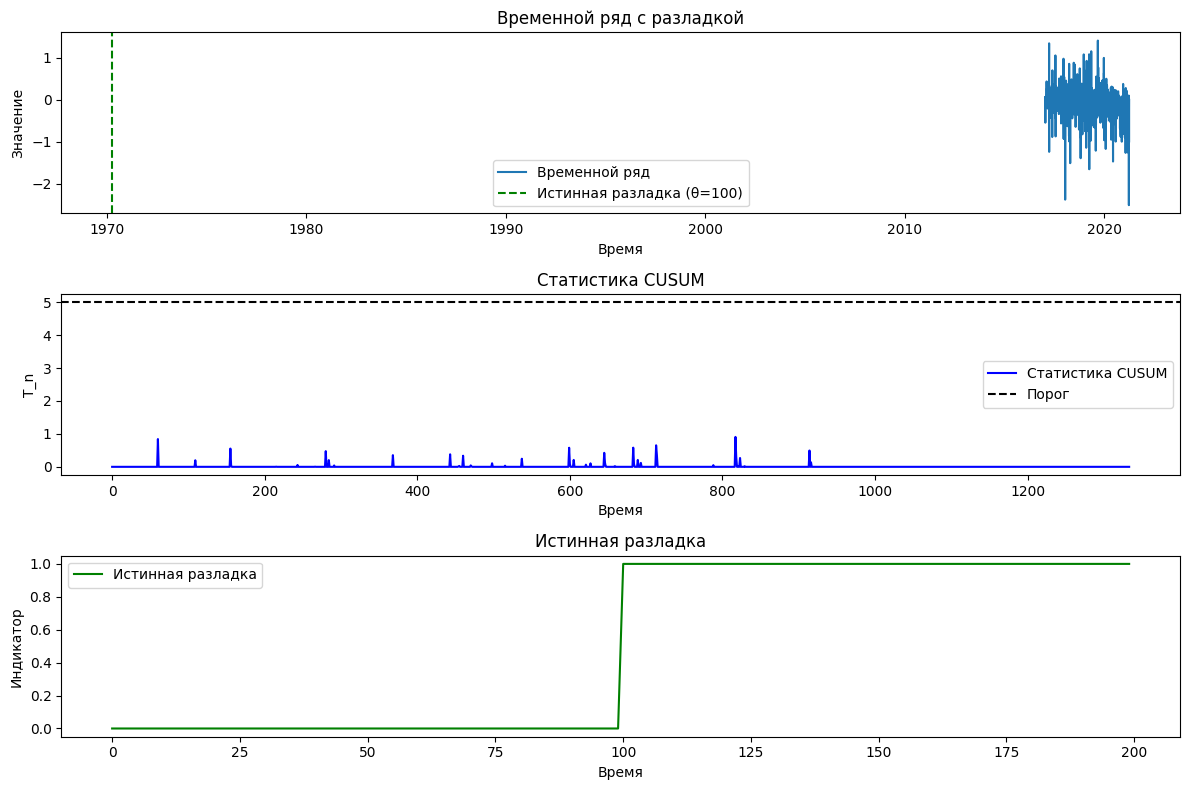

In [80]:
def cusum(data, mu_0=0, mu_1=1, sigma=1, threshold=5):
    """
    Обнаружение разладок с использованием метода CUSUM для нормального распределения.

    :param data: Временной ряд (список или numpy array)
    :param mu_0: Среднее до разладки (H∞)
    :param mu_1: Среднее после разладки (H0)
    :param sigma: Стандартное отклонение (предполагается известным и неизменным)
    :param threshold: Пороговое значение для обнаружения разладки
    :return: Индексы разладок и значения статистики CUSUM
    """
    data = np.array(data)
    T = np.zeros_like(data, dtype=float)  # Статистика CUSUM
    changepoints = []

    # Логарифм отношения правдоподобия для каждой точки
    for n in range(1, len(data)):
        zeta_n = ((mu_1 - mu_0) / (sigma ** 2)) * (data[n] - (mu_0 + mu_1) / 2)
        T[n] = max(0, T[n-1] + zeta_n)
        if T[n] >= threshold:
            changepoints.append(n)
            T[n] = 0  # Сброс после обнаружения разладки

    return changepoints, T

# # Генерация тестовых данных
np.random.seed(42)
n = 200
theta = 100
data_test = np.concatenate([np.random.normal(0, 1, theta), np.random.normal(1, 1, n - theta)])

# Применение CUSUM
changepoints, T_values = cusum(data['Balance'], mu_0=0, mu_1=1, sigma=1, threshold=5)

# Визуализация
plt.figure(figsize=(12, 8))

# График исходных данных
plt.subplot(3, 1, 1)
plt.plot(data['Balance'], label='Временной ряд')
plt.axvline(x=theta, color='g', linestyle='--', label=f'Истинная разладка (θ={theta})')
for cp in changepoints:
    plt.axvline(x=cp, color='r', linestyle='--', label='Обнаруженная разладка' if cp == changepoints[0] else None)
plt.title('Временной ряд с разладкой')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()

# График статистики CUSUM
plt.subplot(3, 1, 2)
plt.plot(T_values, label='Статистика CUSUM', color='b')
plt.axhline(y=5, color='k', linestyle='--', label='Порог')
for cp in changepoints:
    plt.axvline(x=cp, color='r', linestyle='--')
plt.title('Статистика CUSUM')
plt.xlabel('Время')
plt.ylabel('T_n')
plt.legend()

# График истинной разладки
plt.subplot(3, 1, 3)
true_changepoint = np.zeros(n)
true_changepoint[theta:] = 1
plt.plot(true_changepoint, label='Истинная разладка', color='g')
plt.title('Истинная разладка')
plt.xlabel('Время')
plt.ylabel('Индикатор')
plt.legend()
plt.tight_layout()

# Модуль отбора фичей

In [59]:
target = 'Balance'
features = [col for col in data.columns if col not in ['Date', target]]

X = data[features]
y = data[target]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=features)

## встроенные методы отбора признаков
интегрируют отбор признаков в процесс обучения модели. Алгоритм машинного обучения сам оценивает важность признаков во время тренировки, используя свои внутренние механизмы (например, веса или коэффициенты)
- Учитывают взаимодействие между признаками, так как отбор происходит в контексте модели
- Если модель плохо подходит для данных, отбор признаков может быть неоптимальным

diff_2          0.382196
roll_max_3      0.209349
diff_1          0.167861
roll_min_3      0.063410
ratio_ma_3      0.039316
roll_mean_3     0.036178
roll_sum_3      0.032623
ratio_ma_7      0.017782
lag_2           0.013161
Outcome         0.011206
roll_std_3      0.004576
Income          0.003993
roll_std_7      0.002621
roll_max_7      0.001998
roll_min_7      0.001752
roll_std_14     0.001710
roll_min_14     0.001680
lag_1           0.001561
roll_mean_7     0.001420
cummean         0.001044
roll_sum_7      0.000988
lag_7           0.000688
roll_sum_14     0.000645
roll_max_14     0.000623
lag_3           0.000562
roll_mean_14    0.000519
cumsum          0.000511
ratio_lag_1     0.000027
dtype: float64

Выбранные признаки: ['diff_2', 'roll_max_3', 'diff_1', 'roll_min_3', 'ratio_ma_3', 'roll_mean_3', 'roll_sum_3', 'ratio_ma_7', 'lag_2', 'Outcome']


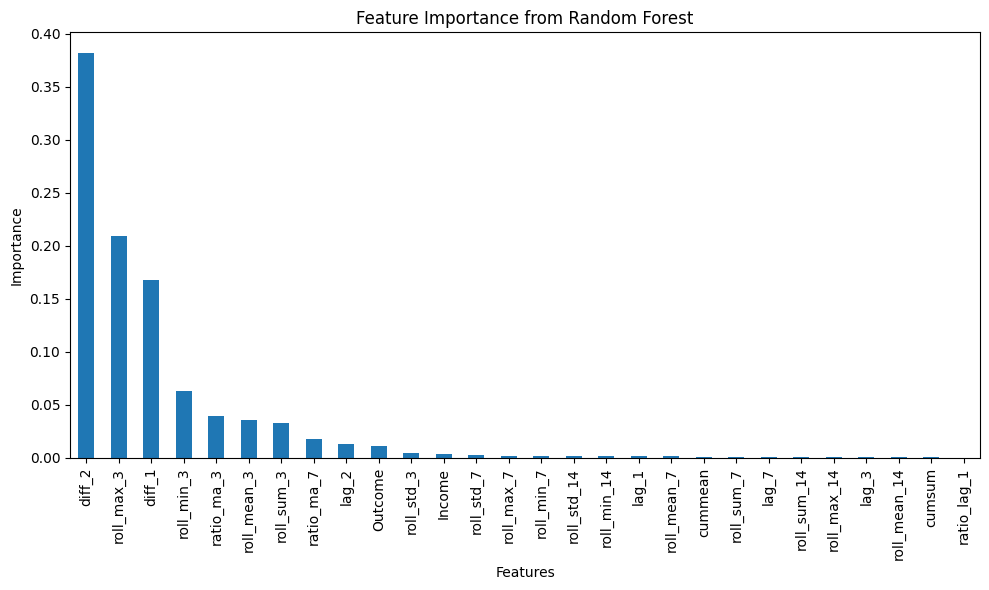

In [61]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_scaled, y)

feature_importance = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
selected_features = feature_importance[feature_importance > 0.01].index.tolist()

print(feature_importance)
print("\nВыбранные признаки:", selected_features)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance from Random Forest')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()

## оберточные методы отбора признаков

оценивают подмножества признаков, обучая модель на каждом подмножестве и измеряя ее производительность
- Учитывают взаимодействие признаков и оптимизируют производительность модели
- Высокая вычислительная сложность, особенно при большом числе признаков (комбинаторный взрыв)
- Риск переобучения, если валидационная выборка мала

In [62]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFE

model = GradientBoostingRegressor(n_estimators=100, random_state=42)
rfe = RFE(estimator=model, n_features_to_select=10)
rfe.fit(X_scaled, y)
selected_features = X_scaled.columns[rfe.support_].tolist()
print("Выбранные признаки:", selected_features)

Выбранные признаки: ['Income', 'lag_2', 'roll_mean_3', 'roll_min_3', 'roll_max_3', 'roll_sum_3', 'diff_1', 'diff_2', 'ratio_ma_3', 'ratio_ma_7']


## фильтрационные методы отбора признаков
оценивают важность признаков независимо от модели, используя статистические или корреляционные метрики
- Быстрые и вычислительно эффективные
- Игнорируют взаимодействие между признаками

In [63]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X_scaled, y, random_state=42)
mi_scores = pd.Series(mi_scores, index=features).sort_values(ascending=False)
selected_features = mi_scores[mi_scores > 0.1].index.tolist()
print("Выбранные признаки:", selected_features)

Выбранные признаки: ['diff_2', 'roll_max_3', 'roll_min_3', 'diff_1', 'Outcome', 'roll_sum_3', 'roll_mean_3', 'ratio_ma_7', 'roll_std_3', 'ratio_ma_3', 'roll_max_7', 'Income', 'roll_min_7', 'ratio_lag_1', 'roll_max_14', 'roll_min_14', 'lag_7', 'roll_std_7', 'roll_sum_7', 'roll_mean_7', 'roll_sum_14', 'lag_2', 'roll_mean_14']
